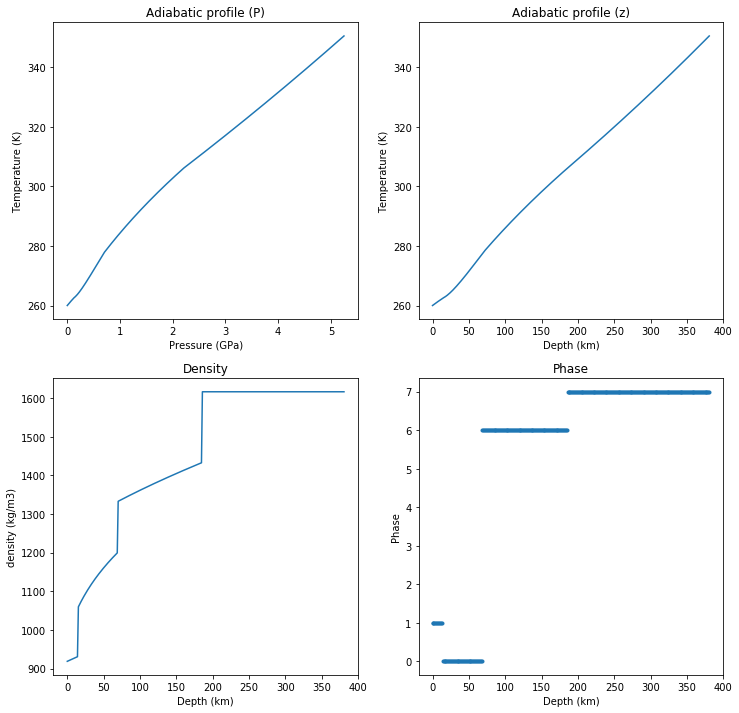

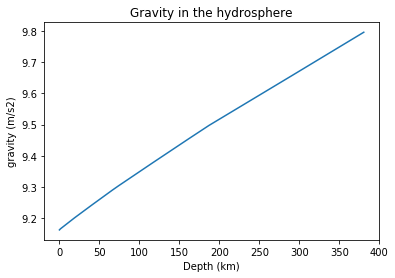

Variable                              Value
----------------------------  -------------
Pressure at surface (bar)       1
Temperature at surface (K)    260
Pressure at HMB (GPa)           5.24827
Temperature at HMB (K)        350.539
Surface Gravity:                9.16133
Mass of water (kg):             3.00083e+23
Mass of water (Earth Ocean):  214.345
Mass of water (Earth Mass):     0.0502466
Mass difference (%):           -0.027641


In [70]:
# HydroSphere v0.6
# Computation of a water-rich planetary body adiabatic profile using SeaFreeze thermodynamics
# with Mass of water as an input
# Baptiste Journaux 2020
import numpy as np
import seafreeze as sf
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import minimize

##### Inputs
P_s = 0.1;   # Starting Pressure (MPa)
T_s = 260   # Starting Temperature (K);
Mass_W_i = 3e+23 # Mass water in kg
r_b = 6370*1e3  #Radius rocky core
rho_core = 5500    # density of the core (kg/m3);

##### Resolution
res = 300;  # depth grid
Mass_it = 3 # Mass convergence itteration: 3-5 is enough (check % Mass difference)
g_it = 3;  # Gravity convergence itteration (3 is enough)

##### Plots and table
plot_flg = 1 # plot flag: 0=no plot; 1=plot
tab_flg =1 # Table flag: 0=no table; 1=table





# Ice VII approximation
rho_VII = 1.6169e+03
alpha_VII = 2.45e-4
Cp_VII = 3400


# Rocky/metal core calculation
Mass_core = 4/3*np.pi*r_b**3*rho_core
g_s = 6.67430e-11*Mass_core/r_b**2 # Gravity at the Hydrosphere Mantle boundary
depth = (Mass_W_i/1100/(4/3*np.pi)+r_b**3)**(1/3)-r_b # Depth approximation in m



for j in range(Mass_it):
    z = np.arange(0, depth, depth/res)  # depth grid
    T = np.zeros(z.size)  # Temperature grid
    P = np.zeros(z.size)  # Pressure grid
    rho = np.zeros(z.size)  # Density grid
    alpha = np.zeros(z.size)  # thermal epansivity grid
    Cp = np.zeros(z.size)  # Heat capacity grid
    dT_dz = np.zeros(z.size)  # thermal gradient grid
    phase = np.zeros(z.size)  # phase grid
    grav = np.zeros(z.size) # gravity grid
    M_L = np.zeros(z.size) # Mass grid
    grav[:]=g_s # Constant gravity to start with
    for k in range(g_it): # Gravity converstion loop
        g = np.flip(grav,0)
        PT = np.empty((1,), np.object)
        PT[0] = (P_s, T_s)
        phase_s = sf.whichphase(PT)
        if P_s > 2200:
            out.rho = rho_VII
            out.alpha = alpha_VII
            out.Cp = Cp_VII
            phase_s = 7 
        else:
            phase_s = sf.whichphase(PT)
            out = sf.seafreeze(PT,sf.phasenum2phase[phase_s[0]])
        rho_s = out.rho  # Density at the surface
        alpha_s = out.alpha  # Thermal expansivity at the surface
        Cp_s = out.Cp  # Heat capacity at the surface
        dT_dz_s = alpha_s*g[0]*T_s/Cp_s  # Thermal gradient at the surface
        T[0] = T_s
        P[0] = P_s
        rho[0] = rho_s
        alpha[0] = alpha_s
        Cp[0] = Cp_s
        dT_dz[0] = dT_dz_s
        phase[0] = phase_s
        for i in range(0,z.size-1):  # Integration with depth
            T[i+1] = T[i]+dT_dz[i]*(z[i+1]-z[i]);
            P[i+1] = P[i]+ rho[i] * g[i] * (z[i+1]-z[i])*1e-6;
            PT[0] = (P[i+1],T[i+1])
            if P[i+1] > 2200:
                out.rho = rho_VII
                out.alpha = alpha_VII
                out.Cp = Cp_VII
                phase[i+1] = 7
            else:
                phase[i+1] = sf.whichphase(PT)
                out = sf.seafreeze(PT,sf.phasenum2phase[phase[i]])
            rho[i+1] = out.rho;
            alpha[i+1] = out.alpha;
            Cp[i+1] = out.Cp;
            dT_dz[i+1] = alpha[i+1]*g[i+1]*T[i+1]/Cp[i+1];

        # Gravity in the hydrosphere
        for i in range(1,len(rho)):
            M_L[i]=rho[i]*4/3*np.pi*((r_b+z[i-1]+(depth/res))**3-(r_b+z[i-1])**3)
        Mass_Shells = np.cumsum(np.flip(M_L,0))
        for i in range(len(rho)):    
            grav[i] = 6.67430e-11*(Mass_core+Mass_Shells[i])/(r_b+z[i])**2  
    # Compute Mass
    Mass_WL = np.sum(M_L)
    Mass_diff = Mass_W_i-Mass_WL
    # depth difference for Mass convergence
    depth_diff = ((Mass_diff)/(np.mean(rho)*1.2)/(4/3*np.pi)+r_b**3)**(1/3)-r_b
    depth = depth + depth_diff

# Compute Mass
E_M_WL = Mass_WL/5.9722e24 # Mass Water Layer in Earth mass
O_M_WL = Mass_WL/1.4e21 # Mass Water Layer in Ocean mass (Earth)
        
    
if plot_flg == 1:        
    fig= plt.figure(figsize=(12,12))
    plt.subplots_adjust(wspace=0.2 , hspace=0.2)
    plt.subplot(221)
    plt.xlabel('Pressure (GPa)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (P)')
    plt.plot(P*1e-3, T, '-')

    plt.subplot(222) 
    plt.xlabel('Depth (km)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (z)')
    plt.plot(z*1e-3, T, '-')

    plt.subplot(223)  
    plt.xlabel('Depth (km)')
    plt.ylabel('density (kg/m3)')
    plt.title('Density')
    plt.plot(z*1e-3, rho, '-')

    plt.subplot(224)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Phase')
    plt.title('Phase')
    plt.plot(z*1e-3, phase, '.')
    
    
    plt.show()
    
    # plot gravity
    plt.xlabel('Depth (km)')
    plt.ylabel('gravity (m/s2)')
    plt.title('Gravity in the hydrosphere')
    plt.plot(z*1e-3, np.flip(grav,0), '-')
    plt.show()




if tab_flg == 1:
    print(tabulate([['Pressure at surface (bar)', P_s*1e1],
                ['Temperature at surface (K)', T_s],
               ['Pressure at HMB (GPa)', max(P)*1e-3],
               ['Temperature at HMB (K)', max(T)],
                ['Surface Gravity:', grav[-1]],
               ['Mass of water (kg):', Mass_WL],
               ['Mass of water (Earth Ocean):', O_M_WL],
               ['Mass of water (Earth Mass):', E_M_WL],
                ['Mass difference (%):', Mass_diff/Mass_W_i*100]],
               headers=['Variable', 'Value']))
